In this notebook, we're going to explore a time-series gait dataset collected from patients with Parkinson's disease. The data is taken from a [PhysioNet](https://www.physionet.org/) repository called [Gait in Parkinson's Disease](https://www.physionet.org/content/gaitpdb/1.0.0/) by Jeffrey Hausdorff.

# Important: Run this code cell each time you start a new session!

In [3]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [2]:
!wget -rNcnp https://physionet.org/files/gaitpdb/1.0.0/

--2024-07-03 23:10:31--  https://physionet.org/files/gaitpdb/1.0.0/
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘physionet.org/files/gaitpdb/1.0.0/index.html’

physionet.org/files     [ <=>                ]  36.17K  --.-KB/s    in 0.04s   

Last-modified header missing -- time-stamps turned off.
2024-07-03 23:10:31 (865 KB/s) - ‘physionet.org/files/gaitpdb/1.0.0/index.html’ saved [37036]

Loading robots.txt; please ignore errors.
--2024-07-03 23:10:31--  https://physionet.org/robots.txt
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 22 [text/plain]
Saving to: ‘physionet.org/robots.txt’

physionet.org/robot 100%[===================>]      22  --.-KB/s    in 0s      

2024-07-03 23:10:31 (9.04 MB/s) - ‘physionet.org/robots.txt’ saved [22/22]

--2024-07-03 23

# Overview of the Dataset

Parkinson's disease is a chronic and progressive neurological disorder that affects the central nervous system. It primarily affects movement and is characterized by a variety of symptoms, including tremors, stiffness, slow movements, and difficulty with balance and coordination. A disturbed gait is a common, debilitating symptom; patients with severe gait disturbances are prone to falls and may lose their functional independence.

The goal of this dataset is to enable researchers to investigate whether characteristics of gait can be used to automatically monitor the severity of Parkinson's disease over time. This dataset is actually composed of data collected by three institutions. Together, these institutions recruited 93 patients with idiopathic PD and 73 healthy controls. During enrollment, subjects were asked to complete a number of clinical scales to assess the severity of their Parkinsonian symptoms. The clinical scale we will focus on the most is the Unified Parkinson's Disease Rating Scale (UPDRS). This scale is composed of four different parts, but we will focus on the portion that deals with motor control function (Part III).


During the study itself, subjects were asked to walk at their usual pace for approximately 2 minutes on level ground. Subjects were asked to repeat this protocol for multiple trials depending on the institution where the data was collected. Underneath each foot were 8 sensors that measure force (in Newtons) as a function of time; the researchers who compiled this dataset refer to the sensor data as the vertical ground reaction force (VGRF). The output of each of these 16 sensors has been digitized and recorded at 100 Hz, and the records also include two signals that reflect the sum of the 8 sensor outputs for each foot.

| Column # | Description |
|----------|-------------|
| 1 | Time in seconds|
| 2–9 | VGRF on each of the 8 sensors located under the left foot |
|10–17 | VGRF on each of the 8 sensors located under the right foot |
| 18 | Total force under the left foot |
| 19 | Total force under the right foot |

The recording files are named according to the following convention: `{study_prefix}{subject_type}{subject_id}_{trial_id}.txt` (e.g., `GaCo01_01.txt`)

* `study_prefix`: Specifies the institution where the subject was recruited (either `Ga`, `Ju`, or `Si`)
* `subject_type`: Specifies whether the subject was a control (`Co`) or a patient (`Pt`)
* `subject_id`: Numerical identifier indicating the subject's number within the institution's cohort
* `trial_id`: Numerical identifier indicating the trial number. We will be looking at all trials except for any numbered `10`, which relates to a special protocol used by a single institution.

All of our data, which has already been downloaded, is located in the folder `physionet.org/files/gaitpbd/1.0.0/`. Along with the recording files, we will also look at the file `demographics.xls`, which contains both subject demographics and their clinical assessment scores.

In [4]:
# The relevant folders and files associated with this dataset
base_folder = os.path.join('physionet.org', 'files', 'gaitpdb', '1.0.0')
demo_filename = os.path.join(base_folder, 'demographics.xls')

In this notebook, we are going to see if we can extract useful information from the VGRF time-series data that is correlated with patients' UDPRS scores. We are going to exclude the healthy controls from our analyses so that we do not have an excess of negligible UPDRS scores. Nevertheless, most of the steps in this notebook could be repeated with that population if you so choose.

# Inspecting the Dataset

Before we start trying to extract information from our images, let's look at a hand-selected example of VGRF time-series data to see what we are working with.

In [5]:
# The names of the columns in the recordings
column_names = ['Time']
for i in range(1, 9):
    column_names.append(f'Left Sensor {i}')
for i in range(1, 9):
    column_names.append(f'Right Sensor {i}')
column_names.append('Left Foot')
column_names.append('Right Foot')

In [6]:
# Show the structure of one of the files
example_filename = 'GaCo01_01.txt'
example_df = pd.read_csv(os.path.join(base_folder, example_filename),
                         sep="\t", header=None, names=column_names)
example_df

,Time,Left Sensor 1,Left Sensor 2,Left Sensor 3,Left Sensor 4,Left Sensor 5,Left Sensor 6,Left Sensor 7,Left Sensor 8,Right Sensor 1,Right Sensor 2,Right Sensor 3,Right Sensor 4,Right Sensor 5,Right Sensor 6,Right Sensor 7,Right Sensor 8,Left Foot,Right Foot
0,0.0000,199.10,87.34,91.08,24.09,21.12,87.67,87.23,64.57,163.90,79.86,112.42,50.82,13.75,102.74,144.98,79.53,662.20,748.00
1,0.0100,199.10,87.34,91.08,24.09,21.12,87.67,87.23,64.57,163.90,79.86,112.42,50.82,13.75,102.74,144.98,79.53,662.20,748.00
2,0.0200,199.10,87.34,91.08,24.09,21.12,87.67,87.23,62.59,163.90,79.86,112.42,50.82,13.75,102.74,144.98,79.53,660.22,748.00
3,0.0300,199.10,87.34,91.08,24.09,21.12,87.67,89.10,64.57,163.90,77.55,112.42,48.07,13.75,105.49,144.98,79.53,664.07,745.69
4,0.0400,199.10,87.34,91.08,24.09,21.12,87.67,87.23,62.59,163.90,77.55,112.42,50.82,13.75,105.49,144.98,79.53,660.22,748.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12114,121.1315,305.91,85.14,58.08,0.00,0.00,0.00,0.00,0.00,15.73,11.66,4.73,33.88,33.00,255.42,432.19,147.29,449.13,933.90
12115,121.1415,331.54,134.75,79.31,11.99,0.00,3.85,0.00,0.00,15.73,9.35,4.73,11.22,24.75,230.34,420.42,151.80,561.44,868.34
12116,121.1515,352.44,181.94,102.96,39.60,0.00,17.49,2.97,0.00,13.97,9.35,4.73,5.61,19.25,192.39,402.82,154.00,697.40,802.12
12117,121.1615,352.44,202.40,124.74,43.01,8.47,50.71,7.59,0.00,13.97,6.93,0.00,0.00,13.75,143.66,373.34,151.80,789.36,703.45


Inspecting time-series data in a table will only give us information about the duration of the recording and the range of values the measurement can take. It's usually a good idea to plot time-series data so we can get a better understanding of its structure.

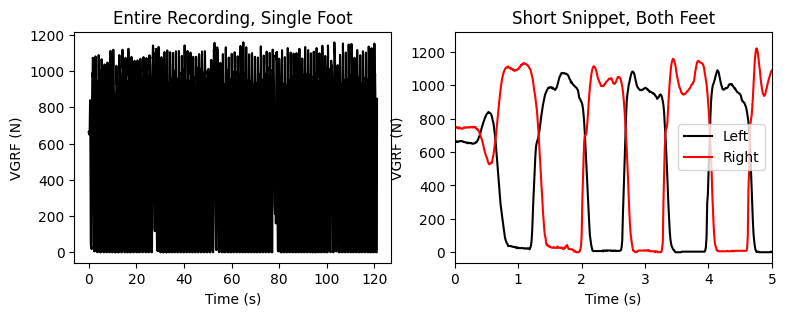

In [7]:
# Plot the data
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.plot(example_df['Time'], example_df['Left Foot'], 'k-', label='Left')
plt.xlabel('Time (s)'), plt.ylabel('VGRF (N)'), plt.title('Entire Recording, Single Foot')
plt.subplot(1, 2, 2)
plt.plot(example_df['Time'], example_df['Left Foot'], 'k-', label='Left')
plt.plot(example_df['Time'], example_df['Right Foot'], 'r-', label='Right')
plt.xlabel('Time (s)'), plt.ylabel('VGRF (N)'), plt.title('Short Snippet, Both Feet')
plt.xlim(0, 5)
plt.legend()
plt.show()

We can verify that the data makes sense for a couple of reasons:
* The measurements recorded from each foot fluctuate between 0 N and roughly 1000 N. While the magnitude of the range's upper limit may not have an intuitive interpretation, the fact that the signals periodically approach zero makes sense since there should be negligible force exerted by the foot while it is up in the air.
* The measurements recorded on each foot oppose one another. In other words, if one signal is high, the other is low. This makes sense since feet alternate when they touch the ground whiel a person is walking.

Let's look at the measurements for a single foot according to three different representations:
1. In the time domain (force vs. time)
2. In the frequency domain as an FFT (FFT amplitude vs. frequency)
3. In the frequency domain as a spectrogram (FFT amplitude vs. frequency vs. time)

In [8]:
from numpy.fft import fftfreq
from scipy.fftpack import fft
from scipy import signal
def view_recording(filename, column_names, fs=100):
    """
    Show the force measurements over time from the left foot according to
    three different representations
    filename: the name of the file that should be loaded
    column_names: the names of the file's columns
    fs: the sampling rate of our data (set to 100 Hz since we know
    that is the case for our dataset)
    """
    # Load the file
    df = pd.read_csv(os.path.join(base_folder, filename),
                     sep="\t", header=None, names=column_names)
    time = df['Time'].values
    values = df['Left Foot'].values

    # Calculate the FFT
    values_centered = values - values.mean()
    fft_mag = np.abs(fft(values_centered))
    fft_freqs = fftfreq(len(values_centered), 1/fs)

    # Calculate the spectrogram
    spec_freqs, spec_times, spectro = signal.spectrogram(values_centered, fs)

    # Show the three signal representations
    plt.figure(figsize=(12, 3))
    plt.subplot(1, 3, 1)
    plt.plot(time, values)
    plt.xlabel('Time (s)'), plt.ylabel('VGRF (N)')
    plt.title('Time Domain')

    plt.subplot(1, 3, 2)
    plt.stem(fft_freqs, fft_mag, markerfmt=" ", basefmt="-")
    plt.xlabel('Freq (Hz)'), plt.ylabel('FFT Amplitude')
    plt.ticklabel_format(axis='y', style='sci', scilimits=(4,4))
    plt.xlim(-0.1, 8)
    plt.title('Frequency Domain: FFT')

    plt.subplot(1, 3, 3), plt.pcolormesh(spec_times, spec_freqs, spectro, shading='gouraud')
    plt.xlabel('Time (s)'), plt.ylabel('Frequency (Hz)')
    plt.ylim(0, 8)
    plt.title('Frequency Domain: Spectrogram')
    plt.show()

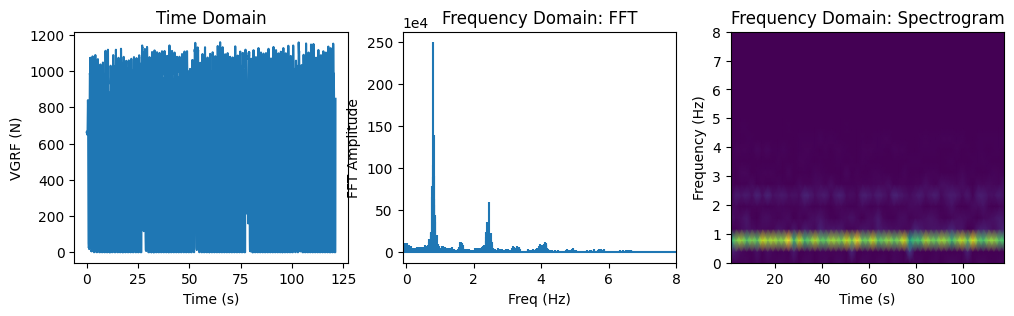

In [9]:
view_recording(example_filename, column_names)

Here are a few notes and observations about this function:
* We removed the mean of the overall signal in the time domain before translating our data into the frequency domain in order to remove the FFT components at 0 Hz.
* Since our data was recorded at 100 Hz, Nyquist–Shannon Sampling Theorem states that we should be able to extract frequency information as high as 50 Hz. However, given that we are talking about gross motor coordination, we aren't going to worry too much about frequency information beyond 8 Hz.
* We could apply a digital filter to clean up our data a bit, but given that there does not seem to be a great deal of high-frequency information, we will forgo that step for now.

# Extracting Information from a Recording

In a previous session, we discussed various time-domain and frequency-domain analysis techniques to summarize time-series data. If we apply all of these techniques, we will be left with hundreds of different metrics we will need to sort through. Although this can be an unbiased way of approaching data analysis, it can also be very time-consuming. For this dataset, we will look at a few standard calculations for each recording; however, we will also apply domain expertise about the problem we are trying to solve to extract information that should ideally be more meaningful to us.

 There are four cardinal symptoms of Parkinson's disease:

1. **Tremor:** Tremor is one of the most common symptoms of Parkinson's disease. It usually begins with a slight trembling or shaking of a hand, finger, or thumb. The tremor typically occurs when the affected limb is at rest and may subside during voluntary movement.

2. **Bradykinesia:** Bradykinesia refers to slowness of movement and is another key symptom of Parkinson's disease. It can manifest as a general reduction in spontaneous movements, including reduced arm swinging while walking, difficulty initiating movement, and a gradual decline in the speed of repetitive actions.

3. **Rigidity:** Rigidity is characterized by stiffness and resistance to movement in the muscles. It can be noticed as increased muscle tone that causes stiffness and resistance, leading to decreased range of motion, muscle aches, and general discomfort.

4. **Postural Instability:** Postural instability is commonly observed in the later stages of Parkinson's disease. It may result in impaired balance and increased risk of falling. People with Parkinson's disease may have difficulty making rapid, automatic, and involuntary adjustments to maintain balance.

Because tremor is more prominent in the hands and arms than it is the legs, we are going to skip that symptom and focus on the latter three.

Knowing how to translate these English explanations into code is a difficult skill that comes with practice, exposure to a diverse toolbox of techniques, and a healthy amount of internet searching for code examples and academic papers. We will cover one way of extracting information related to each rule in order of increasing complexity, but bear in mind two things:

1. There are likely alternative ways of implementing each rule that are just as valid.
2. Some of these techniques are not going to be obvious at first glance, but this is a skill you will develop over time.

## Standard Time-Domain Calculations

To start, let's extract some simple descriptive statistics in the time-domain that will summarize the amplitude of the entire signal. We will calculate the average, standard deviation, 95th percentile, and root mean square (RMS). All of these numbers should be higher under two conditions:
1. Subjects who exert a greater force with their foot (i.e., higher amplitude)
2. Subjects who maintain foot contact for longer periods of time (i.e., wider width).

In [10]:
def compute_arbitrary_time_domain_metrics(times, values, fs=100):
    """
    Calculates generic time-domain statistics on the signal
    times: the times associated with the VGRF data
    values: the VGRF data
    fs: the sampling rate
    """
    return {'average VGRF': np.mean(values),
            'stdev VGRF': np.std(values),
            '95th percentile VGRF': np.percentile(values, 95),
            'rms VGRF': np.sqrt(np.mean(values**2))}

## Standard Frequency-Domain Calculations

Let's also calculate some standard metrics in the frequency domain. We will look at peak frequency a bit later, but for now, we are going to look at the signal's power at different frequency ranges.

When we inspected a randomly selected signal in the frequency domain, we saw that most of the frequency information was within 0–3 Hz, and looking beyond 8 Hz did not give us much new information given how smooth the signal already is. Therefore, we will use 0–3 Hz to define our "low frequency" information and 3–8 Hz to define our "high frequency" information. These decisions are somewhat arbitrary though, so you could try different ranges and see how the influence your results down the road.

The total power within these frequency ranges is heavily correlated with the overall magnitude with which the subject is walking. The harder their steps, the more power there is likely to be across both ranges. To quantify how the frequency content is distributed across these ranges, we will calculate the ratio between the total power in the two ranges.

In [11]:
def compute_arbitrary_freq_domain_metrics(times, values, fs=100):
    """
    Calculates generic frequency-domain statistics on the signal
    times: the times associated with the VGRF data
    values: the VGRF data
    fs: the sampling rate
    """
    # Calculate the FFT
    values_centered = values - values.mean()
    fft_mag = np.abs(fft(values_centered))
    fft_freqs = fftfreq(len(values_centered), 1/fs)

    # Calculate the indices relevant to our frequency bands of interest
    low_indices = np.where((fft_freqs >= 0) & (fft_freqs <= 3))
    high_indices = np.where((fft_freqs >= 3) & (fft_freqs <= 8))

    # Calculate the power at the low and high frequencies
    low_power = np.sum(fft_mag[low_indices]**2)
    high_power = np.sum(fft_mag[high_indices]**2)

    # Calculate the power within the frequency range
    high_to_low_ratio = 10*np.log10(high_power / low_power)
    return {'power at low freqs': low_power,
            'power at high freqs': high_power,
            'high-to-low power ratio': high_to_low_ratio}

## Amplitude Measurements for Rigidity and Postural Instability

The descriptive statistics we have calculated so far have a couple limitations:
1. They do not account for the fact that person's gait characterstics can change over time (e.g., speed up, slow down)
2. For the time-domain calculations in particular, the rate at which the person walks and the force with which they step can affect these statistics.

To account for these shortcomings, we will calculate the signal amplitude (according to RMS) over non-overlapping 5-second windows. This will give us a collection of amplitude measurements that we can aggregate to summarize the entire signal. The decision to use non-overlapping windows is strictly for computational efficiency. The decision to use a 5-second window is somewhat arbitrary, but the general intuition is that it is long enough to include multiple steps and short enough to capture a relatively consistent gait pattern.

The more stiff someone is, the more likely they are to take soft steps. Therefore, we will take the average of the amplitude measurements as a potential metric of rigidity. People who have an unstable gait are more likely to vary their walking behavior over time. Therefore, we will also calculate the standard deviation of the amplitude measurements as a potential metric for postural instability.

In [12]:
def compute_amplitude_metrics(times, values, fs=100):
    """
    Calculate metrics related to the transient amplitude of the signal over time
    using a 5-second window with 0% overlap
    times: the times associated with the VGRF data
    values: the VGRF data
    fs: the sampling rate
    """
    # Set the sliding window parameters
    window_width = 5
    start_time = 0
    end_time = window_width
    sample_period = 1/fs
    middle_idx = int((window_width / sample_period) // 2)

    # Stop generating windows it would go past the end of the signal
    window_amplitudes = []
    while end_time < times.max():
        # Grab the current window by filtering indexes according to time
        window_idxs = (times >= start_time) & (times <= end_time)
        window_values = values[window_idxs]

        # Calculate the amplitude
        window_rms = np.sqrt(np.mean(window_values**2))
        window_amplitudes.append(window_rms)

        # Move the window over by a stride
        start_time += window_width
        end_time += window_width

    # Summarize the amplitude over time
    return {'average amplitude': np.mean(window_amplitudes),
            'stdev amplitude': np.std(window_amplitudes)}

## Cadence Measurements for Bradykinesia and Postural Instability

Walking speed is considered by some clinical researchers to be the "6th vital sign", which makes it an important metric for most gait analyses. Although we cannot easily determine subjects' walking speed in meters per second, we can establish the cadence of their gait in steps per second.

To calculate a subject's cadence over time, we will generate a spectrogram and then look for the peak frequency within each time window. We will then aggregate those frequencies in a similar fashion to how we aggregated the RMS amplitudes earlier. More specifically, we will calculate the average peak frequency over time as a potential metric of bradykinesia, and we will calculate the standard deviation of the peak frequency over time as a potential metric of postural instability.

In [13]:
def compute_cadence_metrics(times, values, fs=100):
    """
    Calculate metrics related to the transient peak frequency of the signal
    over time
    times: the times associated with the VGRF data
    values: the VGRF data
    fs: the sampling rate
    """
    # Calculate the spectrogram
    values_centered = values - values.mean()
    spec_freqs, spec_times, spectro = signal.spectrogram(values_centered, fs)

    # Find the largest bin along the frequency dimension
    dominant_bins = np.argmax(spectro, axis=0)

    # Map those bin indeces to frequencies
    peak_freqs = spec_freqs[dominant_bins]

    # Summarize the step rate over time
    return {'average cadence': np.mean(peak_freqs),
            'stdev cadence': np.std(peak_freqs)}

## Difference Measurements for Postural Instability

We could calculate most of the aforementioned features for both the left and right foot separately, which would nearly double the number of metrics we have. However, should we interpret the step cadence on the left side any differently than the step cadence on the right side? Would we interpret them differently if they were flipped? Probably not.

To make our lives simple, we are going to only calculate the aforementioned metrics on a single side of the body (left). However, it is important to know if the two sides are different. For example, a subject who has a limp may have a heavier footstep on one side compared to the other.

Therefore, we are going to calculate the difference between corresponding metrics on the left and right side of the body. Since we do not care whether the higher value is on the right or left side, we will compute the absolute value of the difference.

In [14]:
def compute_differences(left, right):
    """
    Compares corresponding metrics across two feet
    left: the dictionary of metrics from the left side
    right: the dictionary of metrics from the right side
    """
    diffs_dict = {}
    for key in left:
        diffs_dict[key] = np.abs(left[key] - right[key])
    return diffs_dict

## Processing a Single Recording

Now that we have helper functions to extract information from our recordings, let's put everything together into a single function. This function will take a single recording filename as input and return all of the information calculated for that recording as a `dict`.

In [15]:
def process_recording(filename):
    """
    Process a VGRF recording and produce all of the metrics as a dictionary
    (one value per key)
    filename: the name of the recording file
    """
    # Get the useful columns
    df = pd.read_csv(os.path.join(base_folder, filename),
                     sep="\t", header=None, names=column_names)
    time = df['Time'].values
    left_values = df['Left Foot'].values
    right_values = df['Right Foot'].values

    # Extract metrics from the left side
    left_time = compute_arbitrary_time_domain_metrics(time, left_values)
    left_freq = compute_arbitrary_freq_domain_metrics(time, left_values)
    left_amplitude = compute_amplitude_metrics(time, left_values)
    left_cadence = compute_cadence_metrics(time, left_values)

    # Extract metrics from the right side
    right_time = compute_arbitrary_time_domain_metrics(time, right_values)
    right_freq = compute_arbitrary_freq_domain_metrics(time, right_values)
    right_amplitude = compute_amplitude_metrics(time, right_values)
    right_cadence = compute_cadence_metrics(time, right_values)

    # Extract difference metrics
    diff_time = compute_differences(left_time, right_time)
    diff_freq = compute_differences(left_freq, right_freq)
    diff_amplitude = compute_differences(left_amplitude, right_amplitude)
    diff_cadence = compute_differences(left_cadence, right_cadence)

    # Combine everything into a dictionary
    info_dict = {}
    for left_dict in [left_time, left_freq, left_amplitude, left_cadence]:
        for key in left_dict:
            info_dict['Single foot ' + key] = left_dict[key]
    for diff_dict in [diff_time, diff_freq, diff_amplitude, diff_cadence]:
        for key in diff_dict:
            info_dict['Difference ' + key] = diff_dict[key]
    return info_dict

In [16]:
# Test our function
process_recording(example_filename)

{'Single foot average VGRF': 520.6552240283852,
 'Single foot stdev VGRF': 458.4936828552102,
 'Single foot 95th percentile VGRF': 1081.74,
 'Single foot rms VGRF': 693.7566716985012,
 'Single foot power at low freqs': 15068940744142.945,
 'Single foot power at high freqs': 353020083468.87054,
 'Single foot high-to-low power ratio': -16.302833118028076,
 'Single foot average amplitude': 693.5650280862077,
 'Single foot stdev amplitude': 16.44048359744188,
 'Single foot average cadence': 0.78125,
 'Single foot stdev cadence': 0.0,
 'Difference average VGRF': 42.65903292350856,
 'Difference stdev VGRF': 32.85324752778189,
 'Difference 95th percentile VGRF': 38.5,
 'Difference rms VGRF': 53.73564136033758,
 'Difference power at low freqs': 2273223577071.283,
 'Difference power at high freqs': 8926702413.855286,
 'Difference high-to-low power ratio': 0.7214366649246351,
 'Difference average amplitude': 53.82010854365603,
 'Difference stdev amplitude': 6.527373128313728,
 'Difference averag

# Creating Our Processed Dataset

To process all of our images, we will iterate through all of the files and call our `process_recording()` function on each recording. Because there are a variety of files in our data folder, we will want to ignore any files that either (1) are not recording files, (2) come from control subjects, or (3) are numbered as trial 10. We will gather the results in a single `DataFrame`.

In [17]:
data_filenames = os.listdir(base_folder)

# Iterate through the filenames
info_df = pd.DataFrame()
for data_filename in data_filenames:
    # Skip the file if we want to ignore it
    patient_name = data_filename[0:6]
    patient_type = data_filename[2:4]
    trial_id = data_filename[7:9]
    if (patient_type == 'Co') or (trial_id == '10') or not ('_' in data_filename):
        continue

    # Generate the features
    result_dict = process_recording(data_filename)

    # Add the patient's name as the identifier
    result_dict['ID'] = patient_name
    result_df = pd.DataFrame([result_dict])
    info_df = pd.concat([info_df, result_df], axis=0)

# Set the index to the image name
info_df.set_index(['ID'], inplace=True)
info_df

,Single foot average VGRF,Single foot stdev VGRF,Single foot 95th percentile VGRF,Single foot rms VGRF,Single foot power at low freqs,Single foot power at high freqs,Single foot high-to-low power ratio,Single foot average amplitude,Single foot stdev amplitude,Single foot average cadence,...,Difference stdev VGRF,Difference 95th percentile VGRF,Difference rms VGRF,Difference power at low freqs,Difference power at high freqs,Difference high-to-low power ratio,Difference average amplitude,Difference stdev amplitude,Difference average cadence,Difference stdev cadence
ID,,,,,,,,,,,,,,,,,,,,,
GaPt15,382.810956,325.978645,814.1100,502.798473,7.439453e+12,3.027043e+11,-13.905224,502.937060,9.571692,1.017099,...,94.363098,203.8410,126.749878,4.911676e+12,2.674168e+11,0.547828,125.457957,10.185291,0.036851,0.011733
JuPt06,488.061518,400.526432,967.3950,631.367934,3.747794e+12,5.236589e+10,-18.547272,630.750102,15.653400,0.885417,...,44.747829,78.3475,45.920836,9.014934e+11,5.485188e+09,1.416651,44.896945,4.016460,0.013021,0.007525
JuPt01,565.274344,471.943290,1138.9895,736.386823,3.141142e+12,4.594781e+10,-18.348227,735.078950,23.490190,0.764266,...,33.946543,76.8295,62.520176,4.167899e+11,2.295211e+10,2.387939,62.838020,0.013984,0.000000,0.000000
JuPt14,368.724078,309.336321,731.2800,481.296587,6.611166e+12,8.037159e+10,-19.151755,480.463136,11.597959,0.773738,...,20.695193,39.3800,28.872280,9.029947e+11,1.568242e+10,0.218105,30.150514,1.400941,0.007512,0.021474
SiPt08,513.799734,452.011201,1169.7400,684.327621,1.466875e+13,2.678660e+11,-17.384753,683.001237,43.428866,0.773880,...,41.360025,95.5900,59.957999,2.817461e+12,1.143370e+11,2.470041,59.286104,16.887597,0.007370,0.021288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GaPt31,555.651807,486.366908,1215.4010,738.445462,1.723616e+13,1.181401e+11,-21.640433,738.441723,22.042633,0.795991,...,20.212986,40.9310,16.646354,1.396326e+12,2.595707e+10,0.710565,17.234025,1.651354,0.000000,0.000000
SiPt13,516.331758,422.368172,1009.9100,667.078225,1.280885e+13,2.513473e+11,-17.072359,667.042090,18.222082,0.781250,...,25.612351,59.7300,11.507779,1.664586e+12,5.934293e+10,1.700246,10.842459,3.901380,0.000000,0.000000
JuPt29,343.676608,299.797309,790.0090,456.061440,4.904236e+12,1.128822e+11,-16.379458,456.401003,16.392448,0.831117,...,10.320643,25.2890,14.318924,2.935758e+11,3.975543e+10,1.617408,15.705593,0.480893,0.000000,0.000000


Because some subjects had multiple recordings, their ID will appear multiple times in the index. That is usually not ideal for ensuring that that the each index uniquely points to a single row; however, we are only going to be using the index to combine information about subjects' recordings with their UPDRS scores, so this will not be a big issue.

In [18]:
info_df.loc['JuPt15']

,Single foot average VGRF,Single foot stdev VGRF,Single foot 95th percentile VGRF,Single foot rms VGRF,Single foot power at low freqs,Single foot power at high freqs,Single foot high-to-low power ratio,Single foot average amplitude,Single foot stdev amplitude,Single foot average cadence,...,Difference stdev VGRF,Difference 95th percentile VGRF,Difference rms VGRF,Difference power at low freqs,Difference power at high freqs,Difference high-to-low power ratio,Difference average amplitude,Difference stdev amplitude,Difference average cadence,Difference stdev cadence
ID,,,,,,,,,,,,,,,,,,,,,
JuPt15,486.480835,416.726086,991.3200,640.565558,7.619441e+12,4.471801e+11,-12.314407,641.247171,25.874385,1.097470,...,15.953624,50.3800,18.012111,6.734300e+11,5.028021e+10,0.885833,16.007109,15.249667,0.009301,0.007812
JuPt15,527.461635,456.184112,1114.6520,697.366274,7.313729e+12,5.583959e+11,-11.171966,696.633361,17.171798,1.161595,...,16.301422,8.0300,26.309377,4.803778e+11,8.139450e+10,0.389174,27.010417,0.384322,0.000000,0.000000
JuPt15,524.493572,457.092764,1119.1400,695.720707,7.361654e+12,5.507842e+11,-11.259939,696.165192,20.248906,1.141036,...,18.823945,12.6500,23.403366,5.751886e+11,7.377749e+10,0.271252,25.131870,3.031991,0.000000,0.000000
JuPt15,530.353904,458.088316,1121.1200,700.799664,7.015536e+12,5.364167e+11,-11.165586,699.581072,13.499941,1.150760,...,18.153794,7.1500,31.817425,5.244533e+11,7.617534e+10,0.327729,30.852073,2.334085,0.000000,0.000000
JuPt15,535.635508,462.200832,1119.5800,707.484986,7.409230e+12,5.801044e+11,-11.062669,707.253349,23.939634,1.171875,...,22.704813,20.7570,40.211258,6.523689e+11,1.203571e+11,0.609589,40.565273,4.185447,0.000000,0.000000
JuPt15,529.936697,455.374611,1098.5975,698.712344,8.762058e+12,6.226556e+11,-11.483582,699.089091,14.768402,1.116071,...,20.895932,31.4875,27.614951,6.937085e+11,1.476701e+11,0.817461,28.524882,2.303695,0.000000,0.000000
JuPt15,527.554380,456.757376,1107.9750,697.811525,7.227576e+12,5.462210e+11,-11.216243,698.168616,19.302214,1.151316,...,16.748839,6.4900,26.759948,4.828804e+11,8.241761e+10,0.410042,28.399822,0.987686,0.000000,0.000000


On that note, the demographic information about our subjects is provided in an `.xls` file (note: they are also provided in a tab-limited `.txt` file, but that file has a formatting issue). Let's load this file and see what it looks like:

In [19]:
demo_df = pd.read_excel(demo_filename, index_col='ID')
demo_df

,Study,Group,Subjnum,Gender,Age,Height (meters),Weight (kg),HoehnYahr,UPDRS,UPDRSM,TUAG,Speed_01 (m/sec),Speed_10
ID,,,,,,,,,,,,,
GaPt03,Ga,PD,3,female,82,1.45,50.0,3.0,20.0,10.0,36.34,NaN,0.778
GaPt04,Ga,PD,4,male,68,1.71,NaN,2.5,25.0,8.0,11.00,0.642,0.818
GaPt05,Ga,PD,5,female,82,1.53,51.0,2.5,24.0,5.0,14.50,0.908,0.614
GaPt06,Ga,PD,6,male,72,1.70,82.0,2.0,16.0,13.0,10.47,0.848,0.937
GaPt07,Ga,PD,7,female,53,1.67,54.0,3.0,44.0,22.0,18.34,0.677,0.579
...,...,...,...,...,...,...,...,...,...,...,...,...,...
SiCo26,Si,CO,26,male,60,1.74,72.0,NaN,NaN,NaN,9.20,1.000,NaN
SiCo27,Si,CO,27,male,67,1.90,95.0,NaN,NaN,NaN,12.52,1.120,NaN
SiCo28,Si,CO,28,male,61,1.70,72.0,NaN,NaN,NaN,12.65,0.990,NaN


This file contains many different columns, but we are only going to concern ourselves with the UPDRSM score (i.e., UPDRS Part III) for now.

We are going to do a few things to make this `DataFrame` better serve our needs:
1. We will get rid of all of the rows corresponding to healthy controls
2. We will get rid of all of the columns except for the index and the UPDRSM score.

In [20]:
# Keep only patient data
demo_df = demo_df[demo_df['Group'] == 'PD']

# Get rid of unnecessary columns
score_df = demo_df['UPDRSM']
score_df

ID
GaPt03    10.0
GaPt04     8.0
GaPt05     5.0
GaPt06    13.0
GaPt07    22.0
          ... 
SiPt36    32.0
SiPt37    21.0
SiPt38    14.0
SiPt39    20.0
SiPt40    24.0
Name: UPDRSM, Length: 93, dtype: float64

We now have two `DataFrames` (or technically, a `DataFrame` and a `Series`):
1. `info_df`, which holds all of the characteristics we have extracted from our recordings
2. `score_df`, which holds the UPDRSM scores associated with the subjects

We can combine these together using the function `pd.merge()`. Since we have set the index of `info_df` and `score_df` to be the subject ID, we can use this column as our reference for merging.

It is important to note that each subject completed multiple trials. If we just do a plain `pd.merge()` (i.e., an inner join), we will only have a single row for each subject since that is the list of indices that both `DataFrames` have in common. If we want to have a single row per recording, we will need to do a single-sided join.

In [21]:
df = pd.merge(score_df, info_df, how='right', left_index=True, right_index=True)
df

,UPDRSM,Single foot average VGRF,Single foot stdev VGRF,Single foot 95th percentile VGRF,Single foot rms VGRF,Single foot power at low freqs,Single foot power at high freqs,Single foot high-to-low power ratio,Single foot average amplitude,Single foot stdev amplitude,...,Difference stdev VGRF,Difference 95th percentile VGRF,Difference rms VGRF,Difference power at low freqs,Difference power at high freqs,Difference high-to-low power ratio,Difference average amplitude,Difference stdev amplitude,Difference average cadence,Difference stdev cadence
ID,,,,,,,,,,,,,,,,,,,,,
GaPt03,10.0,343.433216,282.427944,700.480,444.648082,5.831105e+12,2.275241e+10,-24.087234,444.421607,20.608348,...,19.256839,45.760,28.706597,8.148191e+11,1.105764e+10,1.152139,27.958919,0.175975,0.007370,0.007586
GaPt04,8.0,465.003393,390.598070,947.320,607.284948,1.112393e+13,7.665499e+10,-21.617179,606.495716,17.755803,...,5.202262,18.161,21.197996,3.134335e+11,1.261027e+10,0.901248,22.115557,2.678798,0.007370,0.021288
GaPt05,5.0,411.277901,361.974491,820.941,547.882326,9.440699e+12,1.718157e+11,-17.399414,547.556961,19.260221,...,22.689266,36.311,29.221993,1.121864e+12,4.227267e+10,0.677072,29.502260,1.132740,0.000000,0.000000
GaPt06,13.0,557.588702,458.914602,1121.450,722.154951,1.530548e+13,1.418164e+11,-20.331205,721.965836,19.318869,...,5.647152,53.240,28.060753,3.435866e+11,2.775412e+10,0.847240,28.458919,4.186961,0.000000,0.000000
GaPt07,22.0,319.467148,253.540123,684.794,407.850282,4.682924e+12,3.530215e+10,-21.227159,407.763795,23.848561,...,27.310022,38.467,40.351675,1.015065e+12,4.931373e+10,2.944462,39.142952,3.350562,0.007370,0.012917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SiPt36,32.0,358.826789,318.359561,786.500,479.697274,7.337781e+12,9.540862e+10,-18.859771,479.608755,10.832136,...,7.901679,0.319,38.302982,3.132062e+11,5.968487e+10,1.928532,38.333603,4.064862,0.014741,0.037119
SiPt37,21.0,345.079721,284.386913,729.630,447.164321,5.848238e+12,7.668019e+10,-18.823418,446.941313,9.958952,...,11.187253,13.640,8.534774,4.154555e+11,6.003682e+10,2.213339,8.545315,7.355853,0.000000,0.000000
SiPt38,14.0,326.260917,273.404894,670.010,425.671730,5.399695e+12,7.553972e+10,-18.541938,425.577022,9.636840,...,5.800428,9.361,6.813105,2.576747e+11,1.649682e+10,1.272530,6.793150,0.431877,0.007370,0.053148


We can confirm this worked by making sure that we still have multiple entries for subjects who contributed multiple trials.

In [22]:
df.loc['JuPt15']

,UPDRSM,Single foot average VGRF,Single foot stdev VGRF,Single foot 95th percentile VGRF,Single foot rms VGRF,Single foot power at low freqs,Single foot power at high freqs,Single foot high-to-low power ratio,Single foot average amplitude,Single foot stdev amplitude,...,Difference stdev VGRF,Difference 95th percentile VGRF,Difference rms VGRF,Difference power at low freqs,Difference power at high freqs,Difference high-to-low power ratio,Difference average amplitude,Difference stdev amplitude,Difference average cadence,Difference stdev cadence
ID,,,,,,,,,,,,,,,,,,,,,
JuPt15,10.0,486.480835,416.726086,991.3200,640.565558,7.619441e+12,4.471801e+11,-12.314407,641.247171,25.874385,...,15.953624,50.3800,18.012111,6.734300e+11,5.028021e+10,0.885833,16.007109,15.249667,0.009301,0.007812
JuPt15,10.0,527.461635,456.184112,1114.6520,697.366274,7.313729e+12,5.583959e+11,-11.171966,696.633361,17.171798,...,16.301422,8.0300,26.309377,4.803778e+11,8.139450e+10,0.389174,27.010417,0.384322,0.000000,0.000000
JuPt15,10.0,524.493572,457.092764,1119.1400,695.720707,7.361654e+12,5.507842e+11,-11.259939,696.165192,20.248906,...,18.823945,12.6500,23.403366,5.751886e+11,7.377749e+10,0.271252,25.131870,3.031991,0.000000,0.000000
JuPt15,10.0,530.353904,458.088316,1121.1200,700.799664,7.015536e+12,5.364167e+11,-11.165586,699.581072,13.499941,...,18.153794,7.1500,31.817425,5.244533e+11,7.617534e+10,0.327729,30.852073,2.334085,0.000000,0.000000
JuPt15,10.0,535.635508,462.200832,1119.5800,707.484986,7.409230e+12,5.801044e+11,-11.062669,707.253349,23.939634,...,22.704813,20.7570,40.211258,6.523689e+11,1.203571e+11,0.609589,40.565273,4.185447,0.000000,0.000000
JuPt15,10.0,529.936697,455.374611,1098.5975,698.712344,8.762058e+12,6.226556e+11,-11.483582,699.089091,14.768402,...,20.895932,31.4875,27.614951,6.937085e+11,1.476701e+11,0.817461,28.524882,2.303695,0.000000,0.000000
JuPt15,10.0,527.554380,456.757376,1107.9750,697.811525,7.227576e+12,5.462210e+11,-11.216243,698.168616,19.302214,...,16.748839,6.4900,26.759948,4.828804e+11,8.241761e+10,0.410042,28.399822,0.987686,0.000000,0.000000


It is also important to note that some subjects did not complete the UPDRS, so they will have `NaN` as their entry under that column. We will get rid of those rows so that we do not have to deal with missing data:

In [23]:
df = df[~pd.isna(df['UPDRSM'])]
df

,UPDRSM,Single foot average VGRF,Single foot stdev VGRF,Single foot 95th percentile VGRF,Single foot rms VGRF,Single foot power at low freqs,Single foot power at high freqs,Single foot high-to-low power ratio,Single foot average amplitude,Single foot stdev amplitude,...,Difference stdev VGRF,Difference 95th percentile VGRF,Difference rms VGRF,Difference power at low freqs,Difference power at high freqs,Difference high-to-low power ratio,Difference average amplitude,Difference stdev amplitude,Difference average cadence,Difference stdev cadence
ID,,,,,,,,,,,,,,,,,,,,,
GaPt03,10.0,343.433216,282.427944,700.480,444.648082,5.831105e+12,2.275241e+10,-24.087234,444.421607,20.608348,...,19.256839,45.760,28.706597,8.148191e+11,1.105764e+10,1.152139,27.958919,0.175975,0.007370,0.007586
GaPt04,8.0,465.003393,390.598070,947.320,607.284948,1.112393e+13,7.665499e+10,-21.617179,606.495716,17.755803,...,5.202262,18.161,21.197996,3.134335e+11,1.261027e+10,0.901248,22.115557,2.678798,0.007370,0.021288
GaPt05,5.0,411.277901,361.974491,820.941,547.882326,9.440699e+12,1.718157e+11,-17.399414,547.556961,19.260221,...,22.689266,36.311,29.221993,1.121864e+12,4.227267e+10,0.677072,29.502260,1.132740,0.000000,0.000000
GaPt06,13.0,557.588702,458.914602,1121.450,722.154951,1.530548e+13,1.418164e+11,-20.331205,721.965836,19.318869,...,5.647152,53.240,28.060753,3.435866e+11,2.775412e+10,0.847240,28.458919,4.186961,0.000000,0.000000
GaPt07,22.0,319.467148,253.540123,684.794,407.850282,4.682924e+12,3.530215e+10,-21.227159,407.763795,23.848561,...,27.310022,38.467,40.351675,1.015065e+12,4.931373e+10,2.944462,39.142952,3.350562,0.007370,0.012917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SiPt36,32.0,358.826789,318.359561,786.500,479.697274,7.337781e+12,9.540862e+10,-18.859771,479.608755,10.832136,...,7.901679,0.319,38.302982,3.132062e+11,5.968487e+10,1.928532,38.333603,4.064862,0.014741,0.037119
SiPt37,21.0,345.079721,284.386913,729.630,447.164321,5.848238e+12,7.668019e+10,-18.823418,446.941313,9.958952,...,11.187253,13.640,8.534774,4.154555e+11,6.003682e+10,2.213339,8.545315,7.355853,0.000000,0.000000
SiPt38,14.0,326.260917,273.404894,670.010,425.671730,5.399695e+12,7.553972e+10,-18.541938,425.577022,9.636840,...,5.800428,9.361,6.813105,2.576747e+11,1.649682e+10,1.272530,6.793150,0.431877,0.007370,0.053148


# Exploring Our Recording Characterstics

At this point, you could export your `DataFrame` into a `.csv` and explore the image metrics using any tool that you desire (e.g., R, Excel). Nevertheless, we're going to stick with Python to explore our processed dataset.

To make it easy for us to test all of the relevant columns in our `DataFrame`, we will generate a list that holds all of the names of our recording characteristics:

In [24]:
metrics = list(info_df.columns)
metrics

['Single foot average VGRF',
 'Single foot stdev VGRF',
 'Single foot 95th percentile VGRF',
 'Single foot rms VGRF',
 'Single foot power at low freqs',
 'Single foot power at high freqs',
 'Single foot high-to-low power ratio',
 'Single foot average amplitude',
 'Single foot stdev amplitude',
 'Single foot average cadence',
 'Single foot stdev cadence',
 'Difference average VGRF',
 'Difference stdev VGRF',
 'Difference 95th percentile VGRF',
 'Difference rms VGRF',
 'Difference power at low freqs',
 'Difference power at high freqs',
 'Difference high-to-low power ratio',
 'Difference average amplitude',
 'Difference stdev amplitude',
 'Difference average cadence',
 'Difference stdev cadence']

## Descriptive Statistics

Let's start by extracting some descriptive statistics from our data. We can use the `.describe()` method to compute statistics like the mean and range for each column in our entire `DataFrame`:

In [25]:
df.describe()

,UPDRSM,Single foot average VGRF,Single foot stdev VGRF,Single foot 95th percentile VGRF,Single foot rms VGRF,Single foot power at low freqs,Single foot power at high freqs,Single foot high-to-low power ratio,Single foot average amplitude,Single foot stdev amplitude,...,Difference stdev VGRF,Difference 95th percentile VGRF,Difference rms VGRF,Difference power at low freqs,Difference power at high freqs,Difference high-to-low power ratio,Difference average amplitude,Difference stdev amplitude,Difference average cadence,Difference stdev cadence
count,191.000000,191.000000,191.000000,191.000000,191.000000,1.910000e+02,1.910000e+02,191.000000,191.000000,191.000000,...,191.000000,191.000000,191.000000,1.910000e+02,1.910000e+02,191.000000,191.000000,191.000000,191.000000,191.000000
mean,17.853403,458.950865,394.611716,980.369932,605.389384,9.125348e+12,2.786798e+11,-16.316392,605.017464,18.033620,...,22.527866,50.376026,36.562860,1.035664e+12,6.046301e+10,1.024978,36.330735,3.344942,0.006903,0.011111
std,7.050903,71.078548,60.390968,146.881948,92.501234,5.468152e+12,2.766636e+11,4.295874,92.395355,6.994060,...,19.973514,45.634480,32.289309,1.160681e+12,7.370563e+10,0.955355,32.171178,3.345516,0.009715,0.019706
min,5.000000,299.642914,253.370264,667.529500,392.405870,1.036894e+12,1.976352e+10,-25.732338,391.980857,5.702818,...,0.083361,0.220000,0.110271,3.219131e+09,1.078452e+08,0.013493,0.203300,0.003825,0.000000,0.000000
25%,12.000000,413.090986,360.429761,883.355000,553.073303,5.869924e+12,8.439094e+10,-18.948896,552.629779,14.126847,...,6.888937,11.913000,12.243699,2.783461e+11,1.132950e+10,0.324448,11.595675,1.114569,0.000000,0.000000
50%,16.000000,463.190591,392.818629,959.871000,606.379052,8.341056e+12,1.653098e+11,-17.126163,606.017956,17.228361,...,17.154835,38.467000,28.461464,5.495355e+11,2.700131e+10,0.805553,28.458919,2.424269,0.000000,0.000000
75%,23.000000,495.139744,435.409129,1083.307500,658.026140,1.176921e+13,3.953302e+11,-12.582397,657.902790,21.465450,...,31.198020,76.969750,49.208824,1.398623e+12,8.269184e+10,1.379995,49.568164,4.395514,0.010148,0.014412
max,44.000000,637.763281,535.453643,1387.771000,831.346507,4.470654e+13,1.659765e+12,-6.679129,831.067425,73.218059,...,94.363098,203.841000,145.296803,5.672494e+12,3.739029e+11,5.401705,146.188386,19.965595,0.044222,0.123768


Using these results, we can get a sanity check of whether the values we are calculating follow our expectations. Here are some example observations:
* **Single foot 95th percentile VGRF**: Nearly of the recordings have VGRF values that go as high as 950 N while a person is walking.
* **Difference in cadence**: For the most part, subjects have a neglible difference between the cadence of their left and right feet. This makes sense considering most people walk at an even pace.


## Histograms

Although descriptive statistics can distill a lot of data into a small handful of numbers, they can also hide important information about the distribution of our data. Therefore, it can be helpful to generate histograms of our recording characteristics.

The most intuitive way of generating histograms is by calling the corresponding `matplotlib` function. Since we have lots of recording characteristics, we will only display the histograms for the first five:

In [26]:
def generate_histogram(df, col):
    plt.figure(figsize=(3,3))
    plt.hist(df[col], bins=20, color='blue', edgecolor='black',
            alpha=0.7)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {col}')
    plt.show()

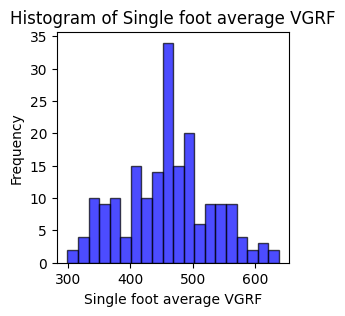

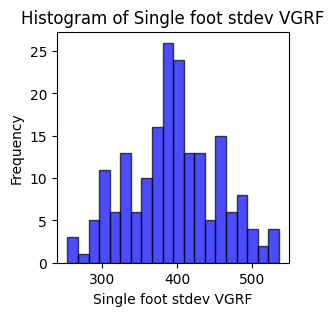

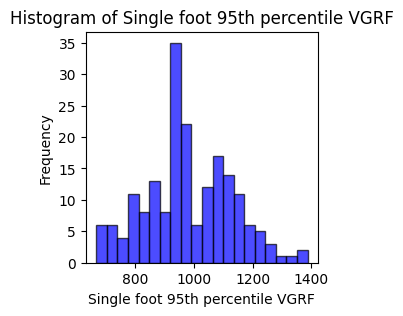

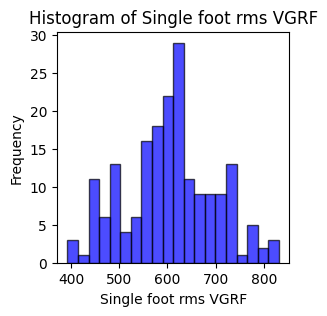

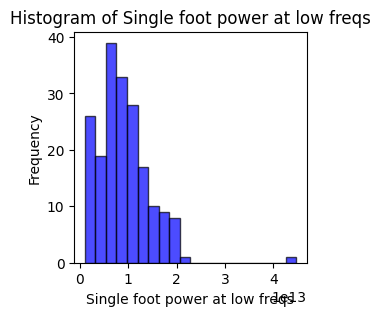

In [27]:
for col in metrics[:5]:
    generate_histogram(df, col)

If you are interested in shortcuts, `pandas` has built-in methods for generating histograms on `Series`:

In [28]:
def generate_histogram(df, col):
    plt.figure(figsize=(3,3))
    df[col].hist(bins=20, alpha=0.7, legend=True)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {col}')
    plt.show()

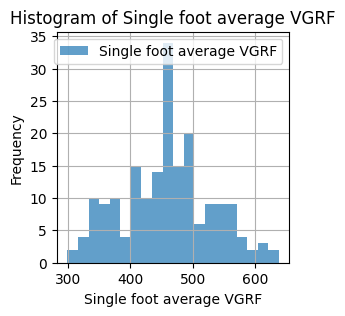

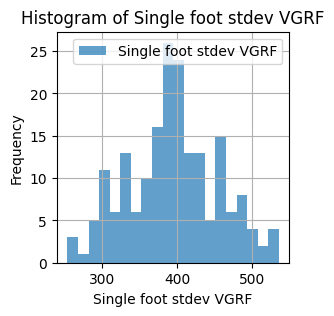

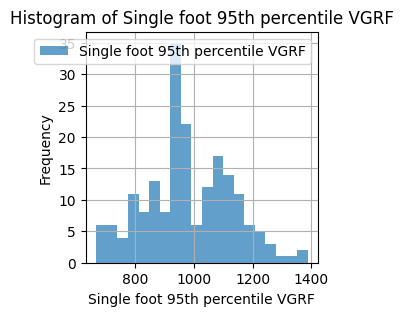

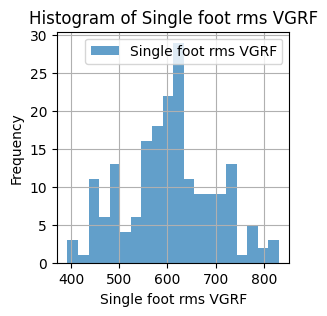

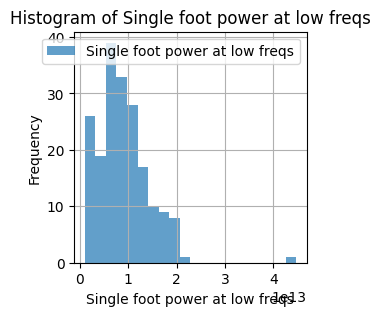

In [29]:
for col in metrics[:5]:
    generate_histogram(df, col)

## Correlations

Up until now, we have only looked at the distribution of individual recording characteristics without any other context. We have not looked at how they vary with respect to UPDRSM score.

One way we can do that is by calculating the correlation coefficient between the UPDRSM score and each recording characteristic. Visually, we can already tell that most of our variables are non-normally distributed. Therefore, we will calculate ***Spearman's rank-order correlation coefficient***. If we knew that our variables were normally distributed, we would use ***Pearson's correlation coefficient***. We can calculate these using functions in the `scipy` library.

In [30]:
from scipy import stats

for col in metrics:
    r, p_value = stats.pearsonr(df[col], df['UPDRSM'])
    print(f"Pearson r for {col}: {r:0.2f}, p-value is {p_value:0.3f}")

Pearson r for Single foot average VGRF: -0.18, p-value is 0.015
Pearson r for Single foot stdev VGRF: -0.17, p-value is 0.022
Pearson r for Single foot 95th percentile VGRF: -0.14, p-value is 0.058
Pearson r for Single foot rms VGRF: -0.17, p-value is 0.017
Pearson r for Single foot power at low freqs: 0.13, p-value is 0.070
Pearson r for Single foot power at high freqs: -0.15, p-value is 0.035
Pearson r for Single foot high-to-low power ratio: -0.19, p-value is 0.010
Pearson r for Single foot average amplitude: -0.17, p-value is 0.017
Pearson r for Single foot stdev amplitude: -0.01, p-value is 0.899
Pearson r for Single foot average cadence: -0.18, p-value is 0.011
Pearson r for Single foot stdev cadence: -0.04, p-value is 0.586
Pearson r for Difference average VGRF: -0.05, p-value is 0.514
Pearson r for Difference stdev VGRF: -0.13, p-value is 0.073
Pearson r for Difference 95th percentile VGRF: -0.07, p-value is 0.329
Pearson r for Difference rms VGRF: -0.09, p-value is 0.207
Pears

We can also also generate a graph illustrate the correlation between these pairs of variables. We will only look at one of the statistically significant pairs for brevity:

In [31]:
def show_correlation(df, col):
    plt.figure(figsize=(3,3))
    plt.plot(df[col], df['UPDRSM'], '*')
    plt.xlabel(col)
    plt.ylabel('UPDRSM')
    plt.title(f'Correlation between UPDRSM and \n{col}')
    plt.show()

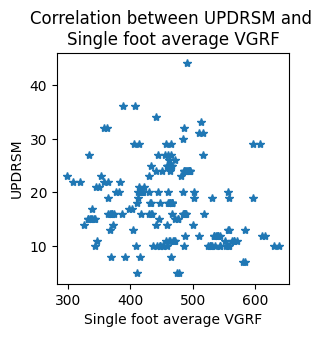

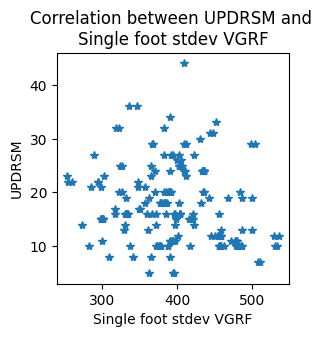

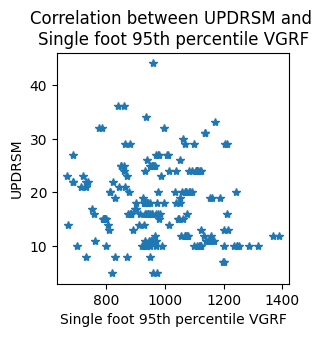

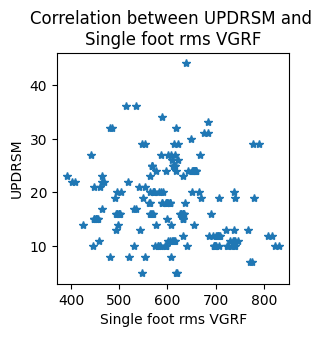

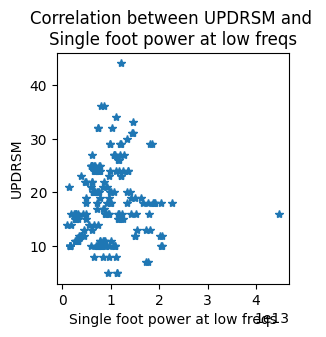

In [32]:
for col in metrics[:5]:
    show_correlation(df, col)

Here are some example observations:
* **Weak correlations:** Nearly all of the correlation coefficient are between ±0.2, indicating that there isn't a single variable strongly associated with UPDRSM
* **Statistically significant results:** At the very least, we do see a few recording characteristics with statistically signficiant correlations, such as "Single foot average VGRF", "Single foot average cadence", and "Difference power at high freqs"

Although these results may be less than ideal for trying to predict a subject's UPDRSM score, that's okay! We're working with real data, and real data is usually messy. In the near future, we will see how machine learning can be used to make sense of this data to achieve that very task.